In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
import lancedb

/Users/sanjith/Computer Science/Qreates/search/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from lancedb.embeddings import EmbeddingFunctionRegistry

registry = EmbeddingFunctionRegistry.get_instance()
clip = registry.get("open-clip").create()

In [5]:
%pip install open_clip_torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 5.0 MB/s eta 0:00:00
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.1 MB/s eta 0:00:000:00:01m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 950.6 kB/s eta 0:00:00eta 0:00:010:00:020m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 945.6 kB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 1.3 MB/s eta 0:00:000:00:01m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.8/284.8 kB 781.7 kB/s eta 0:00:001m862.4 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.8/381.8 kB 1.7 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
clip

OpenClipEmbeddings(max_retries=7, name='ViT-B-32', pretrained='laion2b_s34b_b79k', device='cpu', batch_size=64, normalize=True)

In [7]:
from PIL import Image
from lancedb.pydantic import LanceModel, Vector

class BackgroundImage(LanceModel):
    vector: Vector(clip.ndims()) = clip.VectorField()
    image_uri: str = clip.SourceField()

    @property
    def image(self):
        return Image.open(self.image_uri)

In [8]:
db = lancedb.connect("./.lancedb")

In [ ]:
%pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 38.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.0/508.0 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 19.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
from pathlib import Path
from random import sample

if "background" in db:
    table = db["background"]
else:
    table = db.create_table("background", schema=BackgroundImage)
    # use a sampling of 1000 images
    p = Path("./images/bg").expanduser()
    uris = [str(f) for f in p.glob("*.png")]
    uris = sample(uris, 400)
    table.add(pd.DataFrame({"image_uri": uris}))

100%|██████████| 16/16 [00:00<00:00, 26.45it/s]


In [10]:
table.head().to_pandas()

vector  \
0  [0.03786901, 0.087858826, 0.0030370846, 0.0111...   
1  [0.042221047, 0.14049236, -0.03218991, 0.03641...   
2  [-0.012674432, 0.12582554, -0.004942739, 0.029...   
3  [0.07122931, 0.11325276, 0.035766635, 0.039589...   
4  [0.0061918474, -0.09253492, 0.031230876, 0.004...   

                                           image_uri  
0  images/bg/PINTEREST-archways-containers-1440x1...  
1  images/bg/FREEPIK-wood-surface-white-flowers-p...  
2  images/bg/LIAMJCURTIN-picnic-glass-bottle-1000...  
3  images/bg/FREEPIK-wood-podium-bottle-yellow-fl...  
4  images/bg/PINTEREST-bamboo-leaves-flowers-ging...

# Querying

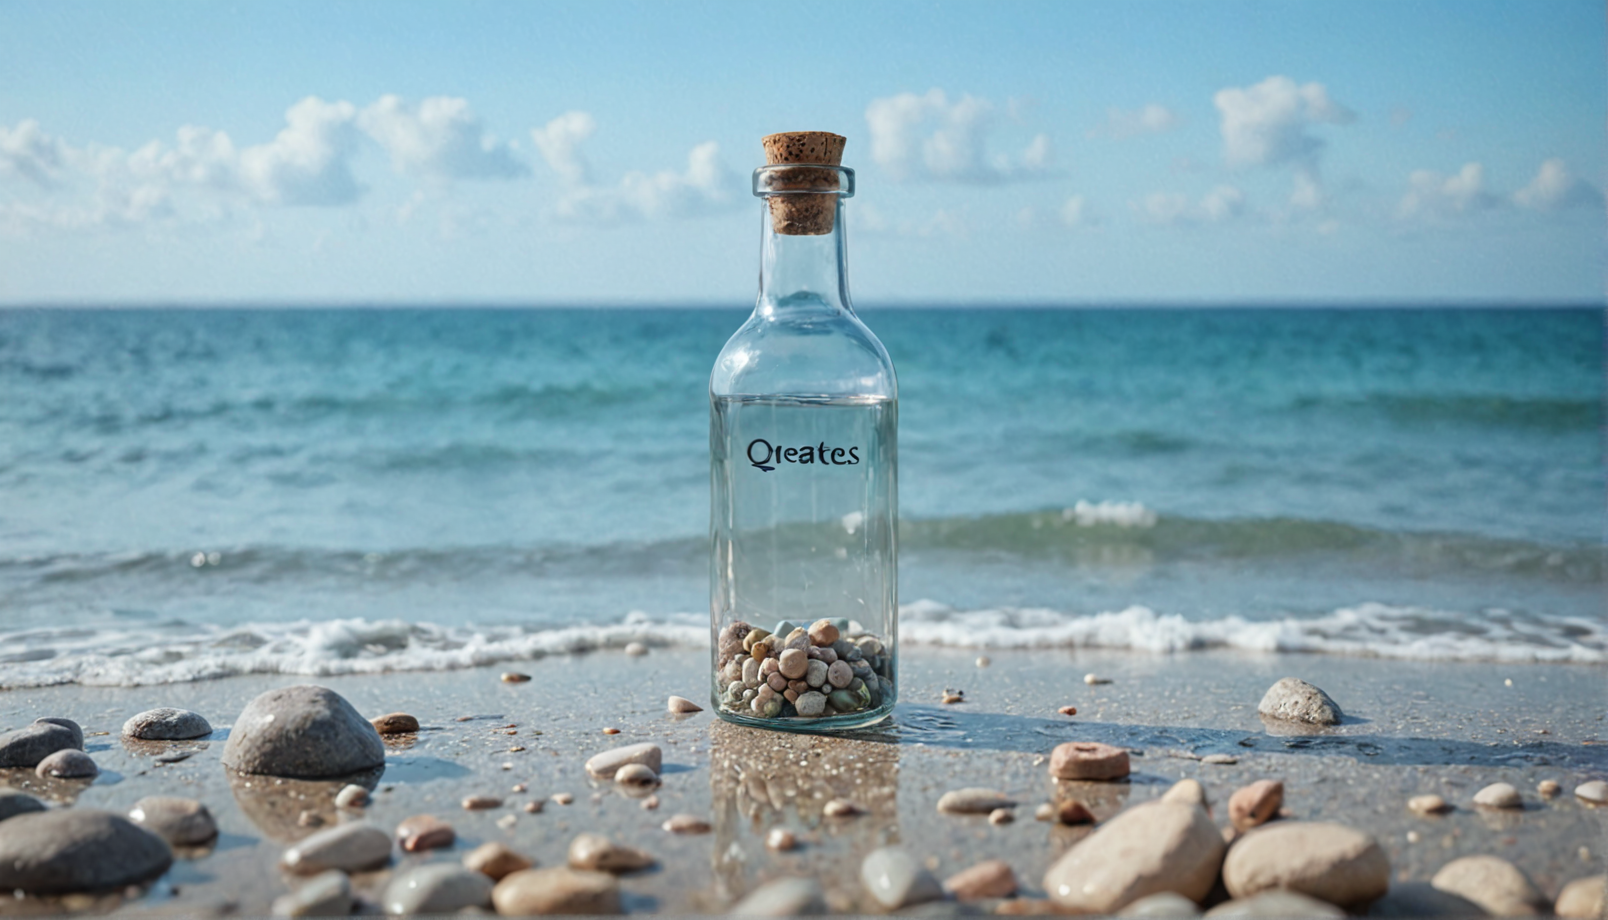

In [11]:
rs = table.search("ocean").limit(3).to_pydantic(BackgroundImage)
rs[0].image

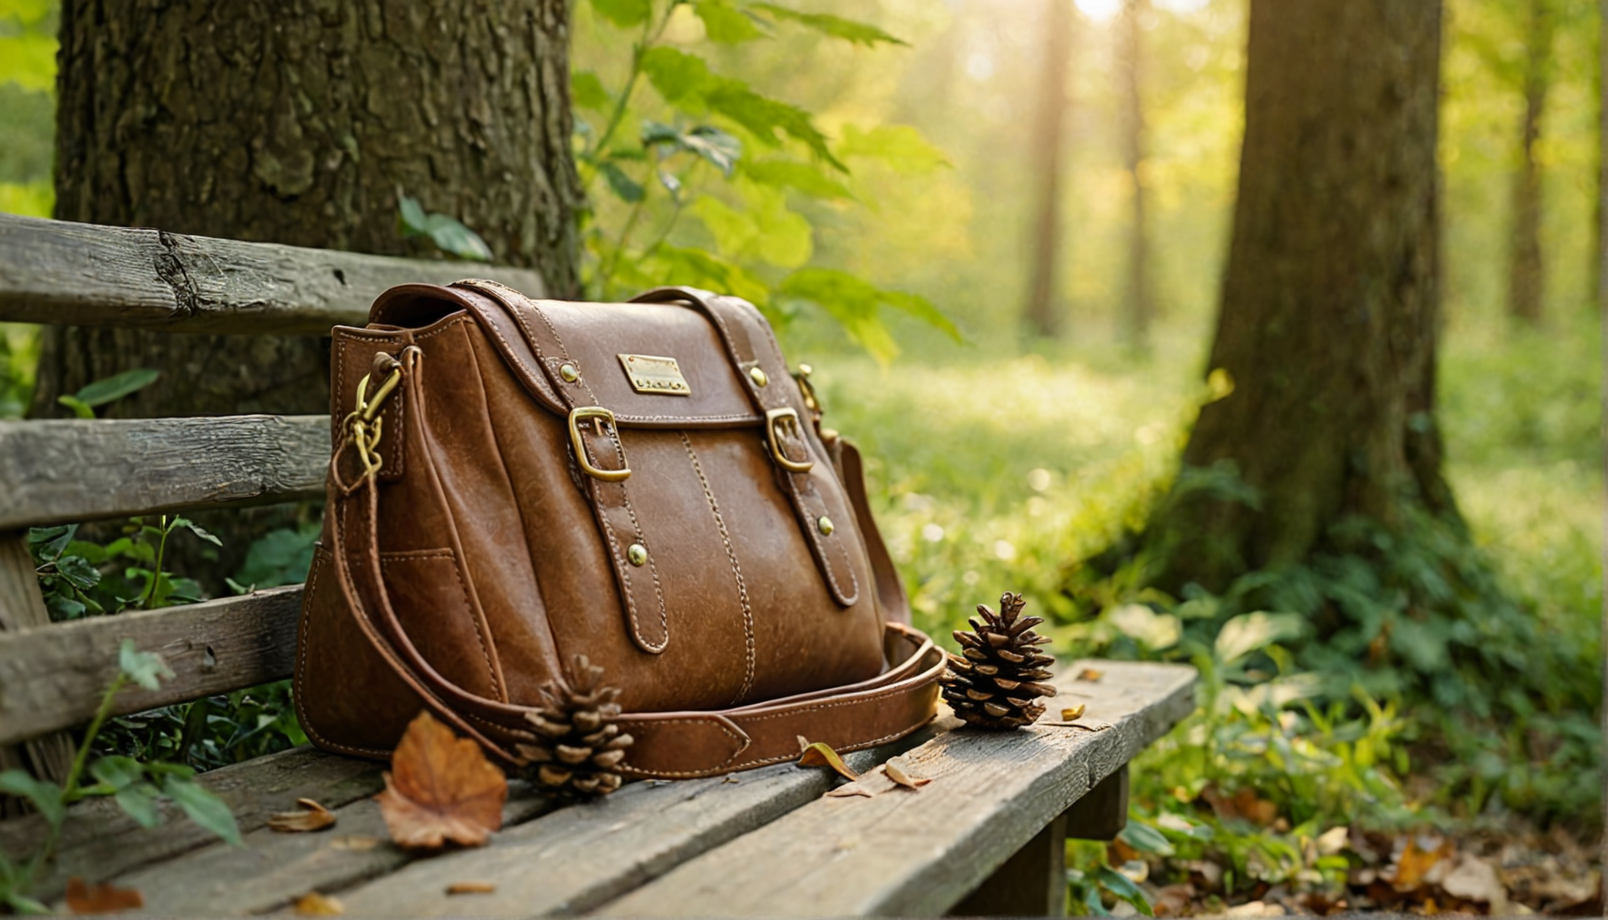

In [ ]:
rs = table.search("forest").limit(3).to_pydantic(BackgroundImage)
rs[0].image

In [13]:
rs[1].image